In [1]:
import numpy as np
import hmvec as hm
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
from cobaya.run import run
from cobaya.theory import Theory
from cobaya.likelihood import Likelihood

In [2]:
#Plot settings
%matplotlib inline
matplotlib.rcParams['axes.labelsize'] = 'xx-large'
matplotlib.rcParams['xtick.labelsize'] = 'x-large'
matplotlib.rcParams['ytick.labelsize'] = 'x-large'
matplotlib.rcParams['legend.fontsize'] = 'x-large'
matplotlib.rcParams['axes.titlesize'] = 'xx-large'

## Setting Up

First, we setup our grid and initialize our halo model. Since this on a shared node on Cori, the (z,m,k) grid we set up is fairly coarse.

In [3]:
#Setup Grid
Nz = 100                                 # num of redshifts
Nm = 100                                 # num of masses
Nk = 1000                                # num of wavenumbers
redshifts = np.linspace(0.01, 6, Nz)             
masses = np.geomspace(1.0e6, 1.0e15, Nm)          
ks = np.geomspace(1.0e-3, 100.0, Nk)              # wavenumbers

In [4]:
#Setup ells to Evaluate Cell at
lowell = 10
highell = 3000
ellstep = 64
ells = np.arange(lowell, highell, ellstep)
Nell = len(ells)

In [5]:
#Initialize Halo Model 
hcos = hm.HaloModel(redshifts, ks, ms=masses, mass_function='tinker')

In [6]:
#params={'As':2.4667392631170437e-09,'ns':.96,'omch2':(0.25-.043)*.7**2,'ombh2':0.044*.7**2,'H0':70.},mdef='mean'

Next, set up the parameters for the CIB model we want. We'll be using Planck 2013 values. We can also give different parameter values (e.g. a dictionary of new values for some/all of the parameters); see 'set_cibParams' documentation for details.

In [7]:
#Set CIB Parameters
hcos.set_cibParams('planck13')

### Fiona's stuff

Redshifts: linspace(0.7, 6, 60)
Masses: logspace(1e10, 1e16, 1983)

In [ ]:
masses = np.load('m.npy')
redshifts = np.load('z.npy')
Nm = len(masses)
Nz = len(redshifts)

In [ ]:
plt.plot(masses, masses)
plt.loglog(masses,masses)

## Frequencies

We need to create a 2x2 array of frequencies. The first axis contains the frequencies to be auto/cross-correlated. The second axis contains the endpoints of a range of frequencies (as in a bandpass).

If you can provide a 1D array containing a single frequency/bandpass, it will assume you want an autocorrelation.

In [8]:
#Autocorrelation: 1 Freq
autofreq = np.array([545e9], dtype=np.double)          

#Autocorrelation: Bandpass
autoband = np.array([540e9, 550e9], dtype=np.double)          

#Cross-Correlation: 1 Freq
crossfreq = np.array([[545e9],[353e9]], dtype=np.double)  

#Cross-Correlation: Bandpass
crossband = np.array([[540e9, 550e9],[347e9, 359e9]], dtype=np.double)   

Let's just stick with a single frequency autocorrelation for now.

## Calculations

Let's do all of the calculations with both the Tinker and Jiang subhalo mass functions. The default in this notebook will be the Jiang (note that this is not the default value for the power functions, which choose Tinker by default).

In [9]:
#Get 3D Power Spectra P(z,k): Tinker
Pjj_tot_tink = hcos.get_power("cib", "cib", nu_obs=autofreq, satmf = 'tinker')  
Pjj_1h_tink = hcos.get_power_1halo("cib", "cib", nu_obs=autofreq, satmf = 'tinker')  
Pjj_2h_tink = hcos.get_power_2halo("cib", "cib", nu_obs=autofreq, satmf = 'tinker')  
Pjj_cen = hcos.get_power("cib", "cib", nu_obs=autofreq, subhalos=False)  # no satellites

In [10]:
#Limber Integrals: Tinker
C_tot_tink, dcdz_tot_tink = hcos.C_ii(ells, redshifts, ks, Pjj_tot_tink, dcdzflag=True)
C_1h_tink, dcdz_1h_tink = hcos.C_ii(ells, redshifts, ks, Pjj_1h_tink, dcdzflag=True)
C_2h_tink, dcdz_2h_tink = hcos.C_ii(ells, redshifts, ks, Pjj_2h_tink, dcdzflag=True)
C_cen, dcdz_cen = hcos.C_ii(ells, redshifts, ks, Pjj_cen, dcdzflag=True)

In [11]:
#Get 3D Power Spectra P(z,k): Jiang
Pjj_tot = hcos.get_power("cib", "cib", nu_obs=autofreq, satmf = 'jiang')  
Pjj_1h = hcos.get_power_1halo("cib", "cib", nu_obs=autofreq, satmf = 'jiang')  
Pjj_2h = hcos.get_power_2halo("cib", "cib", nu_obs=autofreq, satmf = 'jiang')  
Pjj_cen = hcos.get_power("cib", "cib", nu_obs=autofreq, subhalos=False, satmf = 'jiang')  # no satellites

In [12]:
#Limber Integrals: Jiang
C_tot, dcdz_tot = hcos.C_ii(ells, redshifts, ks, Pjj_tot, dcdzflag=True)
C_1h, dcdz_1h = hcos.C_ii(ells, redshifts, ks, Pjj_1h, dcdzflag=True)
C_2h, dcdz_2h = hcos.C_ii(ells, redshifts, ks, Pjj_2h, dcdzflag=True)
C_cen, dcdz_cen = hcos.C_ii(ells, redshifts, ks, Pjj_cen, dcdzflag=True)

## Toy Data for MCMC Code

Get model.

In [26]:
model = np.stack((ells, C_tot_tink), axis=-1)
np.save('toy_model', model)

Use the Lloyd Knox formula for the error estimates.

In [13]:
def knox(ells, fsky, Cl, deltaell, Nl):
    return np.sqrt(2./((2*ells+1) * fsky * deltaell)) * Cl * Nl

#Get Error
fsky = 0.2
Nl = 6
Cerr = knox(ells, fsky, C_tot_tink, ellstep, Nl)

Scatter the data around the model.

In [14]:
from numpy.random import default_rng
rng = default_rng()
ydata = rng.normal(loc=C_tot_tink, scale=Cerr)

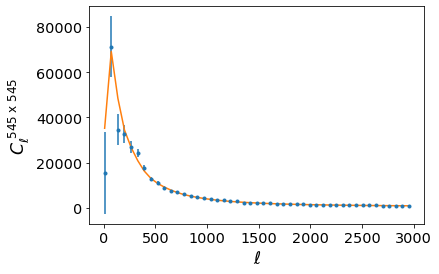

In [15]:
plt.errorbar(ells, ydata, yerr=Cerr, fmt='.')
plt.plot(ells, C_tot_tink)
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C^{\; 545 \;\mathrm{x}\; 545}_\ell$')
plt.yscale('linear');

Signal-to-Noise

In [16]:
np.sqrt(np.sum((ydata/Cerr)**2))

159.23657441776123

Error on $L_o$?

In [17]:
np.sqrt(np.sum((Cerr/ydata)**2))

1.2582370346126315

In [49]:
Lolist = np.linspace(3e-8, 7e-8, num=10)
Ci = np.zeros((len(Lolist), Nell))

for j, Lo in enumerate(Lolist):
    #Calculate
    hcos.set_cibParams('planck13', L_o= Lo)
    P_tink = hcos.get_power("cib", "cib", nu_obs=autofreq, satmf = 'tinker') 
    Ci[j, :] = hcos.C_ii(ells, redshifts, ks, P_tink, dcdzflag=False)  

In [50]:
Cis = Ci

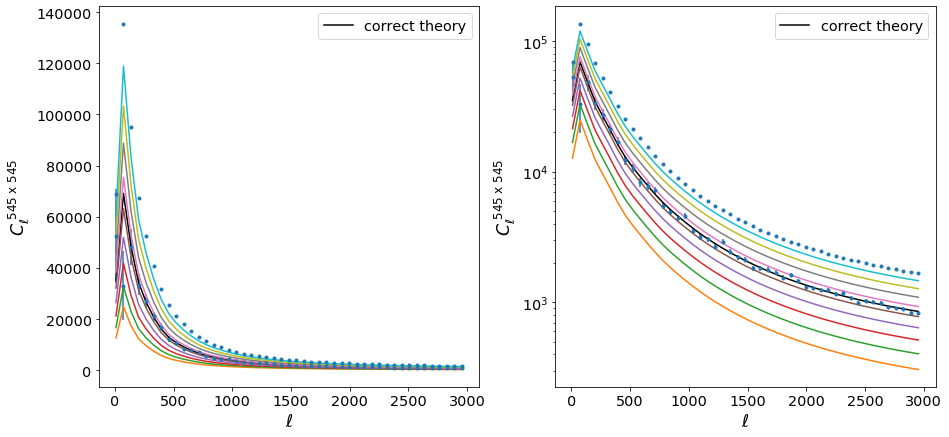

In [51]:
fig, ax = plt.subplots(1,2, figsize=(15,7))

ax[0].errorbar(ells, ydata, yerr=Cerr, fmt='.')
ax[0].plot(ells, C_tot_tink, color='k',label='correct theory')
ax[1].errorbar(ells, ydata, yerr=Cerr, fmt='.')
ax[1].plot(ells, C_tot_tink, color='k',label='correct theory')

for Ctest in Ci:
    #Plot 1
    ax[0].plot(ells, Ctest)
    
    #Plot 2
    ax[1].plot(ells, Ctest)
    
ax[0].set_xlabel(r'$\ell$')
ax[0].set_ylabel(r'$C^{\; 545 \;\mathrm{x}\; 545}_\ell$')
ax[0].legend()
ax[1].set_xlabel(r'$\ell$')
ax[1].set_ylabel(r'$C^{\; 545 \;\mathrm{x}\; 545}_\ell$')
ax[1].set_yscale('log')
plt.legend();

In [52]:
chis = np.ones(len(Lolist))
for i, Ci in enumerate(Cis):
    chis[i] = np.sum(((ydata-Ci) / Cerr)**2)

print(chis/(len(ydata) - 1))
np.sum(((ydata-C_tot_tink) / Cerr)**2)/(len(ydata) - 1)

[220.58587691 148.86134898  84.44177484  33.98444174   4.95358086
   5.62036731  45.06292008 133.16630209 280.62252017 498.93052505]


1.0262984822237542

In [35]:
Lolist

array([3.00000000e-08, 3.44444444e-08, 3.88888889e-08, 4.33333333e-08,
       4.77777778e-08, 5.22222222e-08, 5.66666667e-08, 6.11111111e-08,
       6.55555556e-08, 7.00000000e-08])

In [22]:
55000/47

1170.212765957447

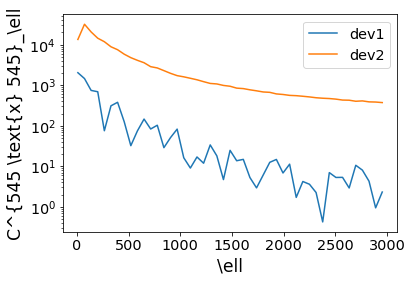

In [48]:
dev1 = np.abs(ydata - C_tot_tink)
dev2 = np.abs(ydata - C2)

plt.plot(ells, dev1, label = 'dev1')
plt.plot(ells, dev2, label = 'dev2')
plt.xlabel(r'\ell')
plt.ylabel(r'C^{545 \text{x} 545}_\ell')
plt.legend()
plt.yscale('log');

1.44

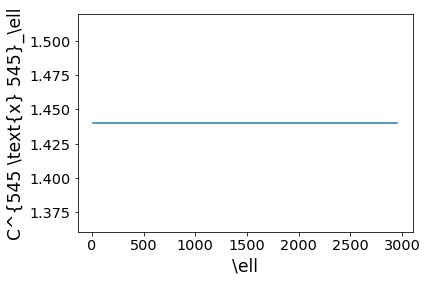

In [57]:
plt.plot(ells, np.abs(C2/C_tot_tink))
plt.xlabel(r'\ell')
plt.ylabel(r'C^{545 \text{x} 545}_\ell')
36/25.

In [18]:
cov = np.diag(Cerr)

In [19]:
np.save('toy_cov', cov)

In [20]:
np.save('toy_data', np.stack((ells, ydata), axis=-1))

## Cobaya

In [ ]:
#Toy Data
filename_cov = 'toy_cov.npy'
filename_data = 'toy_data.npy'
cov = np.load(filename_cov)
data = np.load(filename_data)

#Autocorrelation: 1 Freq
autofreq = np.array([545e9], dtype=np.double)    

#Cobaya Input File
info = {
    "likelihood": {"src_class.ChiSqLikelihood": {"python_path": "~/git/hmvec/"}} ,
    
    "params": dict([
        #CIB Model Parameters
        ("alpha", {
            "prior": {"min": 0, "max": 1.3},
            "ref": {"min": 0.2, "max": 0.5},
            "latex": r"\alpha"}),
        ("beta", {
            "prior": {"min": 0, "max": 2.1},
            "ref": {"min": 1.2, "max": 1.7},
            "latex": r"\beta"}),
        ("gamma", {
            "prior": {"min": 0, "max": 2.7},
            "ref": {"min": 1.2, "max": 1.7},
            "latex": r"\gamma"}),
        ("delta", {
            "prior": {"min": 2.5, "max": 4.6},
            "ref": {"min": 3, "max": 4},
            "latex": r"\delta"}),
        ("Td_o", {
            "prior": {"min": 15, "max": 30},
            "ref": {"min": 18, "max": 22},
            "latex": r"T_{d,o}"}),
        ("logM_eff", {
            "prior": {"min": 11, "max": 14},
            "ref": {"min": 11.8, "max": 13},
            "latex": r"\text{log}(M_{\text{eff}})"}),
        ("L_o", {
            "prior": {"min": 1e-17, "max": 1e-13},
            "ref": {"min": 9e-16, "max": 9e-15},
            "latex": r"L_o"}),
        
        #Fixed Params for Theory/Likelihood
        ("data", data), 
        ("covariance", cov),
        ("freq", autofreq)
    ]),

    "sampler": {
        "mcmc": {"Rminus1_stop": 0.001, "max_tries": 1000}
    },

    "output": "toy/autocib"
}

#Run Cobaya
updated_info, sampler = run(info)

## HaloGen Code

## Plots

Let's first look at the $C$'s with the centrals and the satellites.

In [ ]:
nfn = np.load('nfn.npy')
# plt.plot(masses, nfn[:,0])
nfn.shape

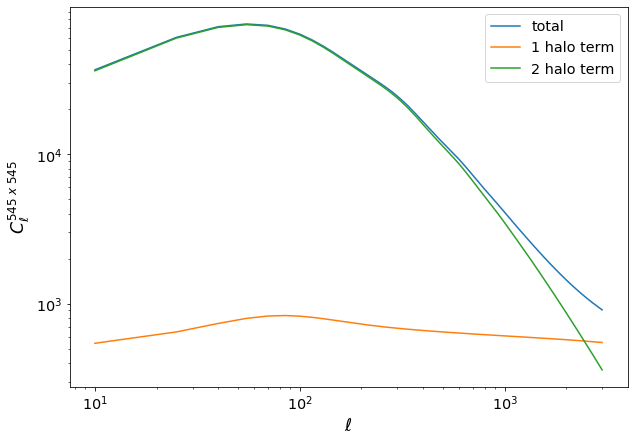

In [69]:
plt.figure(figsize=(10,7))

#Plot C's
plt.loglog(ells, C_tot, label='total')
plt.loglog(ells, C_1h, label='1 halo term')
plt.loglog(ells, C_2h, label='2 halo term')

#Gravy
plt.xlabel(r'$\ell$')
plt.ylabel(rf'$C^{{ {autofreq[0]/1e9:.0f} \; x \; {autofreq[0]/1e9:.0f} }}_\ell$')
plt.legend();

# plt.savefig('cii_1h2h_jiang.pdf', dpi=900, bbox_inches='tight');

Now let's see the total $C$ without any satellites. Note the difference in the magnitude of the power with and without the satellites. The units are not established yet.

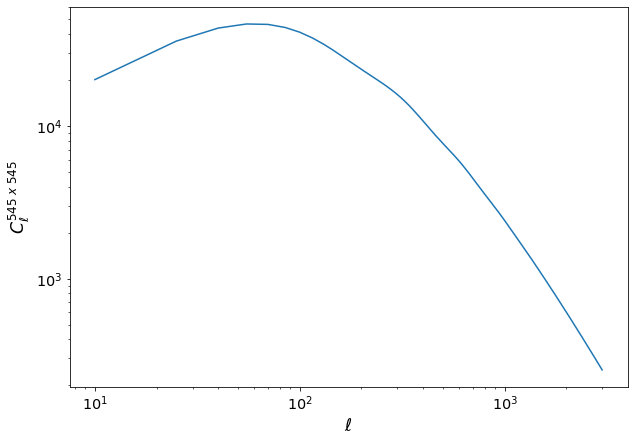

In [70]:
plt.figure(figsize=(10, 7))

#Plot C without Satellites
plt.loglog(ells, C_cen)

#Gravy
plt.xlabel(r'$\ell$')
plt.ylabel(rf'$C^{{ {autofreq[0]/1e9:.0f} \; x \; {autofreq[0]/1e9:.0f} }}_\ell$');

Now let's look at $dC/dz$ with the satellites.

L = 100  :  1.172%


IndexError: index 0 is out of bounds for axis 0 with size 0

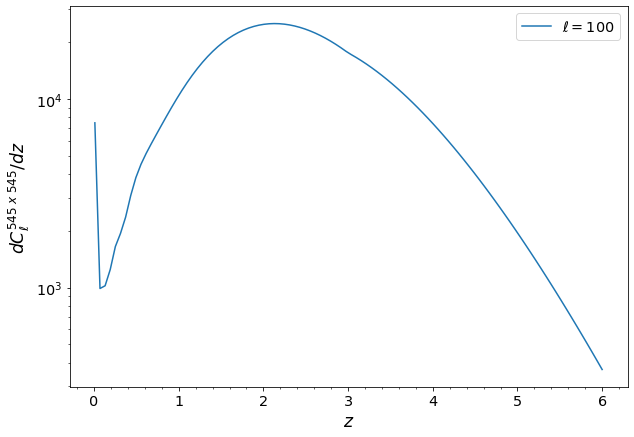

In [71]:
#Plot dC/dz With Satellites
test_ells = np.array([100, 300, 450, 500, 1000])
plt.figure(figsize=(10,7))
for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Spectra
    plt.semilogy(redshifts, dcdz_tot[:, i], label=rf"$\ell = {ells[i]:0.0f}$")
    
    print(f'L = {ell}  :  {np.sum(dcdz_tot[:5, i])/np.sum(dcdz_tot[:, i]) * 100:.3f}%')

    #Gravy
    plt.xlabel(r'$z$')
    plt.ylabel(rf'$dC^{{ {autofreq[0]/1e9:.0f} \;x\; {autofreq[0]/1e9:.0f} }}_\ell / dz$')
    plt.legend()
    plt.minorticks_on()
    
plt.savefig('dcdz_545.pdf', bbox_inches='tight', dpi=600)

In [ ]:
u = hcos.uk_profiles['nfw']
plt.plot(ks, u[1, 135, :])
plt.xlabel('k')
plt.ylabel('NFW');

ux = np.fft.irfft(u)

In [ ]:
redshifts[:10]

In [ ]:
f'{masses[135]:.2e}'

In [ ]:
ells[:10]

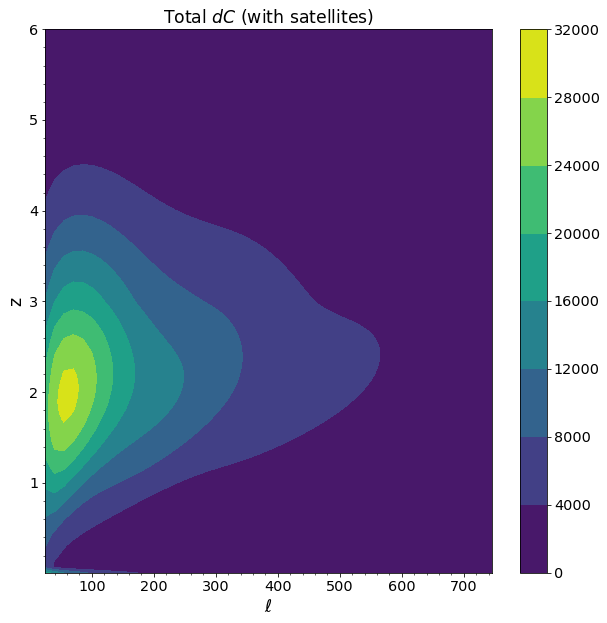

In [72]:
#Setup
plt.figure(figsize=(10,10))

#Plots
zlow = 0
ellow = 1
plt.contourf(ells[ellow:50], redshifts[zlow:100], dcdz_tot[zlow:100, ellow:50])

#Gravy
plt.colorbar()
plt.xlabel(r'$\ell$')
plt.ylabel('z')
plt.title(r'Total $dC$ (with satellites)')
# plt.xlim(10,750)

#Ticks
ax = plt.gca()
# ax.set_yticks(np.arange(0,7))
plt.minorticks_on()

# plt.savefig('dc_jiang.pdf', dpi=900, bbox_inches='tight');

In [ ]:
#Setup
plt.figure(figsize=(10,10))

#Plots
plt.contourf(ells, redshifts, dcdz_1h)

#Gravy
plt.colorbar()
plt.xlabel(r'$\ell$')
plt.ylabel('z')
plt.title(r'1h $dC$ (with satellites)')

#Ticks
ax = plt.gca()
ax.set_yticks(np.arange(0,7))
plt.minorticks_on()

# plt.savefig('dc_1h_jiang.pdf', dpi=900, bbox_inches='tight');

In [ ]:
#Setup
plt.figure(figsize=(10,10))

#Plots
plt.contourf(ells, redshifts, dcdz_2h)

#Gravy
plt.colorbar()
plt.xlabel(r'$\ell$')
plt.ylabel('z')
plt.title(r'2h $dC$ (with satellites)')

#Ticks
ax = plt.gca()
ax.set_yticks(np.arange(0,7))
plt.minorticks_on();

# plt.savefig('dc_2h_jiang.pdf', dpi=900, bbox_inches='tight');

And $dC/dz$ without the satellites.

In [ ]:
#Plot dC/dz With Satellites
test_ells = np.array([100, 300, 500, 1000])
plt.figure(figsize=(10,7))
for ell in test_ells:
    #Get index
    i = np.where(abs(ell - ells) <= 1)[0][0]

    #Spectra
    plt.semilogy(redshifts, dcdz_cen[:, i], label=rf"$\ell = {ells[i]:0.0f}$")

    #Gravy
    plt.xlabel(r'$z$')
    plt.ylabel(rf'$dC^{{ {autofreq[0]:.2e} \;x\; {autofreq[0]:.2e} }} / dz$')
    plt.legend()
    plt.minorticks_on();